In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import os
from scipy import stats

In [2]:
# Section 1: Load Data

In [5]:
# Define data types (optimize for memory and correctness)
dtypes = {
    "PERMNO": "Int64",         # Use nullable integer type for identifiers
    "RET": "object",           # Daily return (parsed as string first)
    "DLRET": "object",         # Delisting return (parsed as string first)
    "PRC": "float64",          # Price
    "VOL": "float64",          # Volume
    "SHROUT": "float64",       # Shares outstanding
    "SHRCD": "Int16",          # Share code (10/11 = common shares)
    "EXCHCD": "Int8",          # Exchange code (1=NYSE, 2=AMEX, 3=NASDAQ)
    "CFACPR": "float64",       # Price adjustment factor
    "CFACSHR": "float64",      # Share adjustment factor
    "DLSTCD": "Int16"          # Delisting code (200-399 = delisting)
}

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()

# Construct path to the data file
data_file = os.path.join(notebook_dir, "daily stock price.csv")

# Load data
df = pd.read_csv(
    data_file,
    dtype=dtypes,
    parse_dates=["date"]  # Parse 'date' column as datetime
)

# Convert date column to datetime with YYYYMMDD format (if not already parsed correctly)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')

In [6]:
# Convert returns to numeric (coerce errors to NaN)
df["RET"] = pd.to_numeric(df["RET"], errors="coerce")
df["DLRET"] = pd.to_numeric(df["DLRET"], errors="coerce")

# Drop rows with missing critical values (PRC, VOL, SHROUT, CFACPR, CFACSHR)
df = df.dropna(subset=["PRC", "VOL", "SHROUT", "CFACPR", "CFACSHR"])

# Handle delisting returns (Shumway, 1997)
# First, handle missing values in DLSTCD
df["DLSTCD"] = df["DLSTCD"].fillna(0)  # Fill NA with 0 (not a delisting code)

# Create a boolean mask for delisting codes (200-399)
mask = df["DLSTCD"].between(200, 399)

# Apply the mask to replace RET with DLRET for delisted stocks
df["RET"] = np.where(
    mask,          # Condition: True for delisting codes
    df["DLRET"],   # Use delisting return
    df["RET"]      # Keep original return otherwise
)

# Fill remaining missing returns (non-delisted stocks) with -0.30
df["RET"] = df["RET"].fillna(-0.30)

In [7]:
# Adjust for Corporate Actions (Price, Volume, Shares) ---
# Replace zeros in adjustment factors with 1 (no adjustment)
df["CFACPR"] = df["CFACPR"].replace(0, 1)
df["CFACSHR"] = df["CFACSHR"].replace(0, 1)

# Adjust price, volume, and shares outstanding
df["adj_prc"] = df["PRC"] / df["CFACPR"]  # Correct split/dividend adjustment
df["adj_shrout"] = (df["SHROUT"] * 1000) * df["CFACSHR"]  # Recorded in Thousands
df["adj_volume"] = df["VOL"] * df["CFACSHR"]

# Convert to float32
df["adj_prc"] = df["adj_prc"].astype("float32")

df["adj_volume"] = df["adj_volume"].astype("float32")

# Calculate dollar volume (amihud denominator)
df["dollar_volume"] = df["adj_prc"].abs() * df["adj_volume"]

# Compute daily Amihud ratio
df["amihud_daily"] = df["RET"].abs() / df["dollar_volume"]

# Handle invalid values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
invalid_rows = df["amihud_daily"].isna().sum()
print(f"Dropped {invalid_rows} rows due to invalid Amihud values.")
df.dropna(subset=["amihud_daily"], inplace=True)

Dropped 65209 rows due to invalid Amihud values.


In [8]:
# Precompute daily market cap and handle negative values
df["daily_market_cap"] = df["adj_prc"] * df["adj_shrout"]
df["daily_market_cap"] = df["daily_market_cap"].where(df["daily_market_cap"] >= 0, np.nan)  # Set negatives to NaN

In [9]:
# Filters
df["RET"] = np.where( # Filter 1
    (df["RET"].abs() > 2),
    np.nan,
    df["RET"]
)

df["adj_volume"] = np.where(  # Filter 2
    df["adj_volume"] > df["adj_shrout"],
    np.nan,
    df["adj_volume"]
)
df["dollar_volume"] = df["adj_prc"].abs() * df["adj_volume"]
df["adj_volume"] = np.where(  # Filter 3
    df["dollar_volume"] < 100,
    np.nan,
    df["adj_volume"]
)

In [10]:
# Section 2: Portfolio formation

In [12]:
# Step 1: Aggregate to monthly data
df_monthly = df.groupby(["PERMNO", pd.Grouper(key="date", freq="M")]) \
               .agg(
                   monthly_RET=("RET", lambda x: (1 + x).prod() - 1),
                   amihud=("amihud_daily", lambda x: x.mean() * 1e6),  # Scale Amihud
                   market_cap=("daily_market_cap", "mean"),
                   EXCHCD=("EXCHCD", "last")
               ).reset_index()

In [13]:
# --- Step 2: Lag Variables to Avoid Look-Ahead Bias ---
df_monthly = df_monthly.sort_values(by=["PERMNO", "date"])
df_monthly["lagged_amihud"] = df_monthly.groupby("PERMNO")["amihud"].shift(1)
df_monthly["lagged_market_cap"] = df_monthly.groupby("PERMNO")["market_cap"].shift(1)

# Drop rows with missing lagged data (first month for each stock)
df_monthly = df_monthly.dropna(subset=["lagged_amihud", "lagged_market_cap"])

In [14]:
# --- Step 3: Rank and Assign Portfolios Monthly ---
df_monthly["liquidity_rank"] = df_monthly.groupby("date")["lagged_amihud"].rank(ascending=True, pct=True)
df_monthly["portfolio"] = pd.qcut(df_monthly["liquidity_rank"], q=10, labels=False, duplicates="drop")
df_monthly["valid_from"] = df_monthly["date"] + pd.offsets.MonthBegin(1)
df_portfolios = df_monthly[["PERMNO", "date", "valid_from", "portfolio", "lagged_market_cap"]]

In [16]:
# --- Step 4: Merge Daily Data with Monthly Portfolios Efficiently ---
# Sort DataFrames by the merge keys
df = df.sort_values("date")  # Sort by date alone for merge_asof
df_portfolios = df_portfolios.sort_values("valid_from")  # Sort by valid_from

# Ensure PERMNO in df_portfolios is Int64
df_portfolios["PERMNO"] = df_portfolios["PERMNO"].astype("Int64")

# Use merge_asof to align daily data with the most recent portfolio assignment
df_daily_with_portfolio = pd.merge_asof(
    df[["PERMNO", "date", "RET", "EXCHCD", "daily_market_cap"]],
    df_portfolios[["PERMNO", "valid_from", "portfolio", "lagged_market_cap"]],
    by="PERMNO",
    left_on="date",
    right_on="valid_from",
    direction="backward"  # Match to the most recent valid_from before or on the date
).dropna(subset=["portfolio"])
df_daily_with_portfolio = df_daily_with_portfolio[df_daily_with_portfolio["lagged_market_cap"] > 0]

In [17]:
# Define the cache file path
cache_file = "df_daily_with_portfolio.pkl"
df_daily_with_portfolio.to_pickle(cache_file)
print(f"Processed data saved to {cache_file}.")

Processed data saved to df_daily_with_portfolio.pkl.


In [18]:
# --- Step 5: Compute Daily Portfolio Returns ---
# Daily Value-Weighted (including NASDAQ)
df_daily_with_portfolio["ret_cap"] = df_daily_with_portfolio["RET"] * df_daily_with_portfolio["lagged_market_cap"]

daily_vw_returns = (
    df_daily_with_portfolio.groupby(["date", "portfolio"])[["ret_cap", "lagged_market_cap"]]
    .sum()
    .assign(vw_return=lambda x: x["ret_cap"] / x["lagged_market_cap"])
    ["vw_return"]
    .unstack()
    .fillna(0)
)

cumulative_vw_daily = (1 + daily_vw_returns).cumprod()

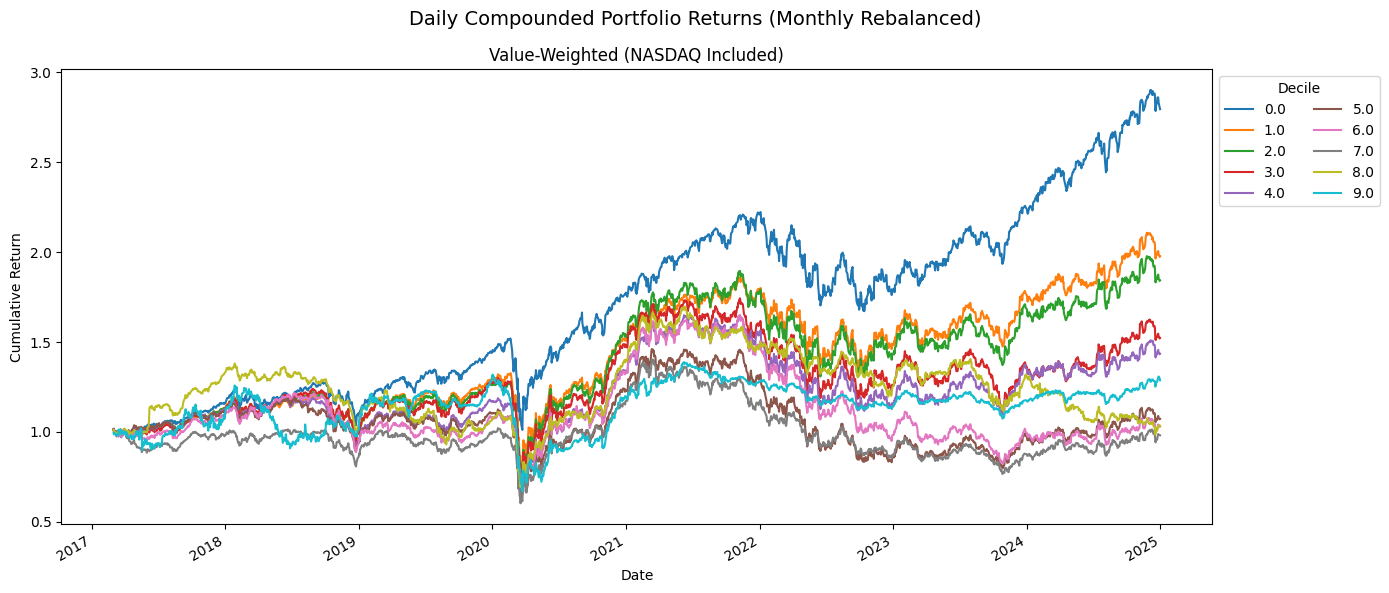

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot on the single axis
cumulative_vw_daily.plot(
    ax=ax,
    title="Value-Weighted (NASDAQ Included)",
    xlabel="Date",
    ylabel="Cumulative Return"
)

# Adjust legend to avoid overlapping
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Decile", ncol=2)

# Add overall title (optional)
plt.suptitle("Daily Compounded Portfolio Returns (Monthly Rebalanced)", y=0.98, fontsize=14)

# Tight layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()

In [24]:
# Construct the ILLIQ factor: High Amihud (portfolio 9) minus Low Amihud (portfolio 0)
# Compute daily value-weighted returns (including NASDAQ)
illiq_factor_vw = daily_vw_returns[9] - daily_vw_returns[0]
illiq_factor_vw = illiq_factor_vw.rename("ILLIQ_VW")

# Display the first few rows of the ILLIQ factors
print("\nILLIQ Factor (Value-Weighted, including NASDAQ):")
print(illiq_factor_vw.head())

# Save ILLIQ factor (portable path)
illiq_vw_file = os.path.join(notebook_dir, "illiq_factor_vw.csv")
illiq_factor_vw.to_csv(illiq_vw_file)
print(f"\nILLIQ factor saved to: {illiq_vw_file}")


ILLIQ Factor (Value-Weighted, including NASDAQ):
date
2017-03-01   -0.018349
2017-03-02   -0.002471
2017-03-03    0.007744
2017-03-06   -0.005591
2017-03-07    0.003078
Name: ILLIQ_VW, dtype: float64

ILLIQ factor saved to: C:\Users\s1155163244\Downloads\Group G FYP Materials\Factors Investing Advisor\illiq_factor_vw.csv


In [21]:
# Daily Equal-Weighted (including NASDAQ)
daily_ew_returns = df_daily_with_portfolio.groupby(["date", "portfolio"])["RET"].mean().unstack()
cumulative_ew_daily = (1 + daily_ew_returns).cumprod()

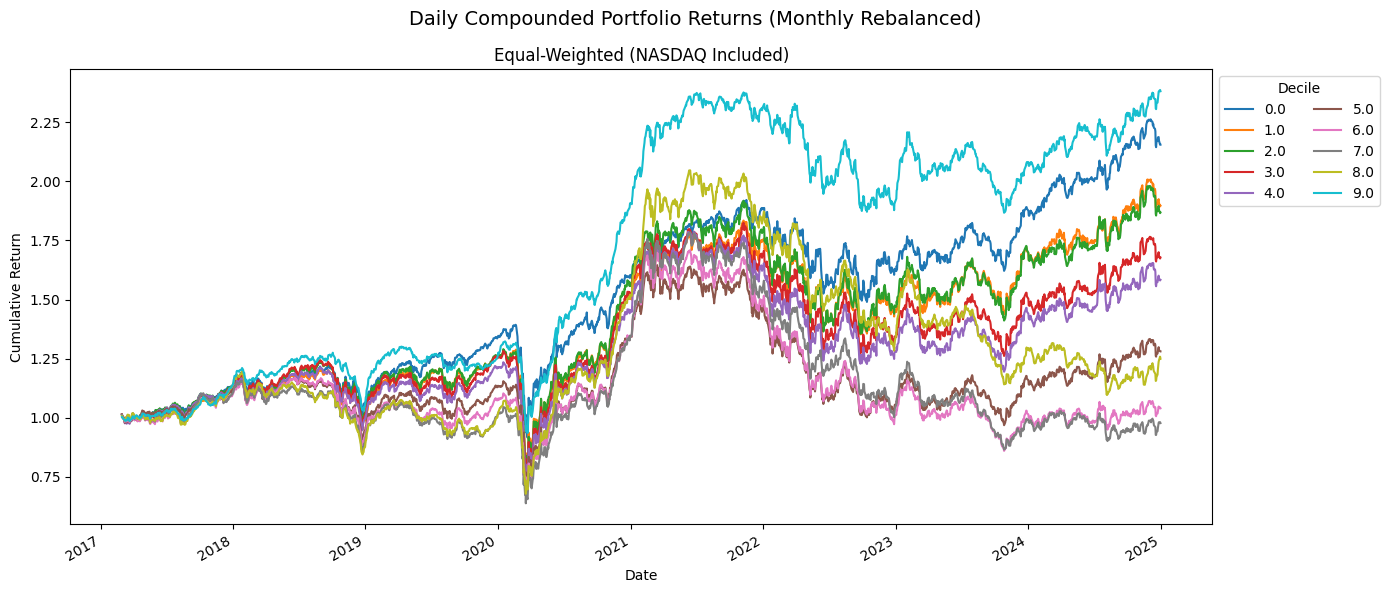

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot on the single axis
cumulative_ew_daily.plot(
    ax=ax,
    title="Equal-Weighted (NASDAQ Included)",
    xlabel="Date",
    ylabel="Cumulative Return"
)

# Adjust legend to avoid overlapping
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Decile", ncol=2)

# Add overall title (optional)
plt.suptitle("Daily Compounded Portfolio Returns (Monthly Rebalanced)", y=0.98, fontsize=14)

# Tight layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()

In [26]:
# Construct the ILLIQ factor: High Amihud (portfolio 9) minus Low Amihud (portfolio 0)
# Compute daily equal-weighted returns (including NASDAQ)
illiq_factor_ew = daily_ew_returns[9] - daily_ew_returns[0]
illiq_factor_ew = illiq_factor_ew.rename("ILLIQ_EW")

# Display the first few rows of the ILLIQ factors
print("\nILLIQ Factor (Value-Weighted, including NASDAQ):")
print(illiq_factor_ew.head())

# Save ILLIQ factor (portable path)
illiq_ew_file = os.path.join(notebook_dir, "illiq_factor_ew.csv")
illiq_factor_ew.to_csv(illiq_ew_file)
print(f"\nILLIQ factor saved to: {illiq_ew_file}")


ILLIQ Factor (Value-Weighted, including NASDAQ):
date
2017-03-01   -0.007537
2017-03-02    0.005265
2017-03-03   -0.002104
2017-03-06   -0.002069
2017-03-07    0.003736
Name: ILLIQ_EW, dtype: float64

ILLIQ factor saved to: C:\Users\s1155163244\Downloads\Group G FYP Materials\Factors Investing Advisor\illiq_factor_ew.csv
